### AHN3 Interpolation Techniques: local setting

Exploratory analysis and result

In [4]:
import os
import glob

import math
import numpy as np
from laspy.file import File
import pandas as pd

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
from mpl_toolkits.axes_grid1 import AxesGrid

import seaborn as sns

import rasterio
from rasterio.plot import show

In [9]:
#Read LAS file
inFile = File("./las/CPUT_Lidar.las", mode = "r")

In [10]:
print('Examining Point Format: ')
pointformat = inFile.point_format
for spec in inFile.point_format:
    print(spec.name)

Examining Point Format: 
X
Y
Z
intensity
flag_byte
raw_classification
scan_angle_rank
user_data
pt_src_id
gps_time
red
green
blue
extra_bytes


In [11]:
#Import LAS into numpy array 
lidar_points = np.array((inFile.x, inFile.y, inFile.z, inFile.intensity,
                         inFile.raw_classification, inFile.scan_angle_rank,
                        # inFile.red, inFile.green, inFile.blue
                        )).transpose() # inFile.return_number,

#colors = np.vstack((inFile.red, inFile.green, inFile.blue)).transpose()
print(len(lidar_points))

2960297


In [14]:
#Transform to pandas DataFrame
lidar_df = pd.DataFrame(lidar_points, columns=['x', 'y', 'z', 'intensity', 'class',
                                              'scan_angle'])
lidar_df.describe()

,x,y,z,intensity,class,scan_angle
count,2.960297e+06,2.960297e+06,2.960297e+06,2.960297e+06,2.960297e+06,2960297.0
mean,-3.313425e+04,-3.756192e+06,6.473786e+01,8.418275e+01,1.579262e+00,0.0
std,3.077179e+02,2.183977e+02,4.435219e+00,6.953237e+01,4.936777e-01,0.0
min,-3.377966e+04,-3.756653e+06,-3.087800e+01,0.000000e+00,1.000000e+00,0.0
25%,-3.338573e+04,-3.756378e+06,6.166000e+01,3.600000e+01,1.000000e+00,0.0
50%,-3.316080e+04,-3.756182e+06,6.294000e+01,8.500000e+01,2.000000e+00,0.0
75%,-3.289473e+04,-3.756005e+06,6.710000e+01,1.220000e+02,2.000000e+00,0.0
max,-3.253820e+04,-3.755738e+06,7.141500e+02,4.936300e+04,2.000000e+00,0.0


In [7]:
print('diff x:', lidar_df.x.min() - lidar_df.x.max())
print('diff y:', lidar_df.y.min() - lidar_df.y.max())
print('diff z:', lidar_df.z.min() - lidar_df.z.max())

diff x: -1241.4600000000028
diff y: -915.1100000003353
diff z: -745.028


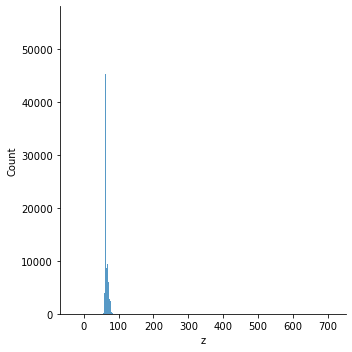

In [8]:
sns.displot(lidar_df.z)
plt.show()

In [15]:
factor=30
decimated_points_random = lidar_df[::factor]
print(len(decimated_points_random))

98677


In [16]:
extent = x_min, x_max, y_min, y_max = [lidar_df.x.min()-50, 
                                       lidar_df.x.max()+50,
                                       lidar_df.y.min()-50, 
                                       lidar_df.y.max()+50]
extent

[-33829.658, -32488.198, -3756703.188, -3755688.0779999997]

In [17]:
#do the same but use a different method
size = 1
header = inFile.header
extents = [[header.min[0], header.max[0]],
           [header.min[1], header.max[1]]]
res = [math.ceil((extents[0][1] - extents[0][0]) / size),
       math.ceil((extents[1][1] - extents[1][0]) / size)]
ll_origin = [np.mean(extents[0]) - (size / 2) * res[0],
             np.mean(extents[1]) - (size / 2) * res[1]]
ul_origin = [np.mean(extents[0]) - (size / 2) * res[0],
             np.mean(extents[1]) + (size / 2) * res[1]]

print(ll_origin)
print(ul_origin)

[-33779.928, -3756653.633]
[-33779.928, -3755737.633]


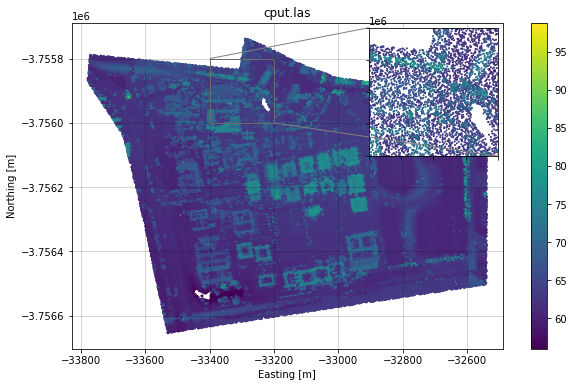

In [14]:
fig, ax = plt.subplots(figsize=(10,6))

cm = ax.scatter(decimated_points_random.x, decimated_points_random.y, 
                c=decimated_points_random.z,
                #c=decimated_points_random.intensity, 
                #c=decimated_points_random.scan_angle,
                s=4)
ax.set_aspect(1)
ax.set_xlim(*extent[:2])
ax.set_ylim(*extent[2:])
ax.set_xlabel('Easting [m]')
ax.set_ylabel('Northing [m]')
ax.set_title('cput.las')
ax.grid(c='k', alpha=0.2)
fig.colorbar(cm)

axins = zoomed_inset_axes(ax, 2, loc=1)
axins.scatter((decimated_points_random.x), (decimated_points_random.y), 
              c=decimated_points_random.z,
              #c=(decimated_points_random.intensity),
              #c=(decimated_points_random.scan_angle),
              s=1)
axins.set_xlim(-33400, -33200)
axins.set_ylim(-3756000, -3755800)
plt.xticks(visible=False)
plt.yticks(visible=False)
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")


plt.show()

#### dtm

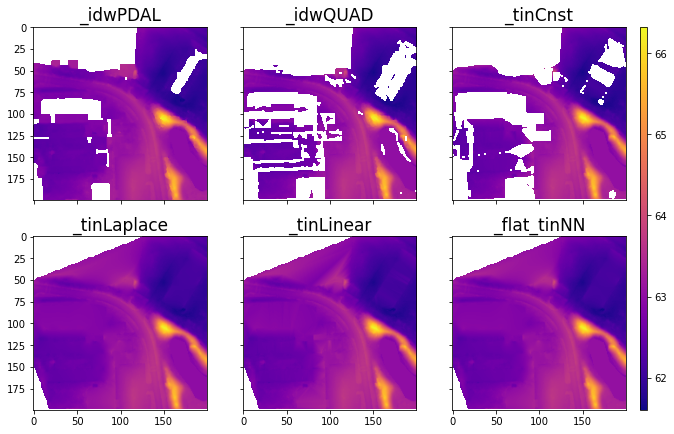

In [27]:
#define a function to plot ~ dtm, dtm and the vertical differences [LiDAR - dtm/dsm]
def plot_ra_tif(path, dtm = False, diff = False):
    files =  glob.glob(os.path.join(path), 
                       recursive=True)
    img_l = []
    #char2 = '.asc'
    char2 = '.tif'
    if dtm == True:
        ind = '_dtm'
        c = plt.cm.plasma
    else:
        ind = '_dsm'
        c = plt.cm.jet
        
    if diff == True:
        ind = 'vertical_'
        c = plt.cm.RdYlGn
    
    for file in files:
        ds = rasterio.open(file)#.ReadAsArray()
        array = ds.read(1)
        nan_array = array
        nan_array[array == -9999] = np.nan
        nan_array  = np.flip(nan_array, 0)

        img_l.append(nan_array)
        ds = None
        
    fig = plt.figure(figsize=(11, 11))
    grid = AxesGrid(fig, 111, 
                    nrows_ncols=(2, 3),
                    axes_pad=0.5,
                    share_all=True,
                    cbar_mode='single',
                    cbar_location='right',
                    cbar_size="2%",
                    cbar_pad=0.2)

    for ax, i, g in zip(grid, img_l, files):
    #ax.set_axis_off()
        im = ax.imshow(i, cmap=c)
        ax.set_title(g.split(ind)[1].split('.tif')[0], 
                         fontdict={'fontsize': 17, 'fontweight': 'medium'})
        
    # when cbar_mode is 'single', for ax in grid, ax.cax = grid.cbar_axes[0]
    cbar = ax.cax.colorbar(im)
    cbar = grid.cbar_axes[0].colorbar(im)
    plt.show()
    
#with flat and constraint
plot_ra_tif('./[!o]**/CPUT_Lidar_dtm*.tif', dtm = True)

#### dtm difference

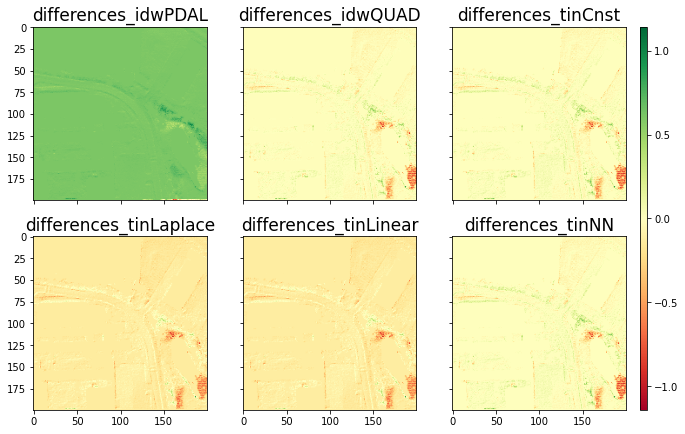

In [31]:
plot_ra_tif('./vDiff/**/CPUT_Lidar_dtm*vertical*.tif', diff = True)

#### dsm

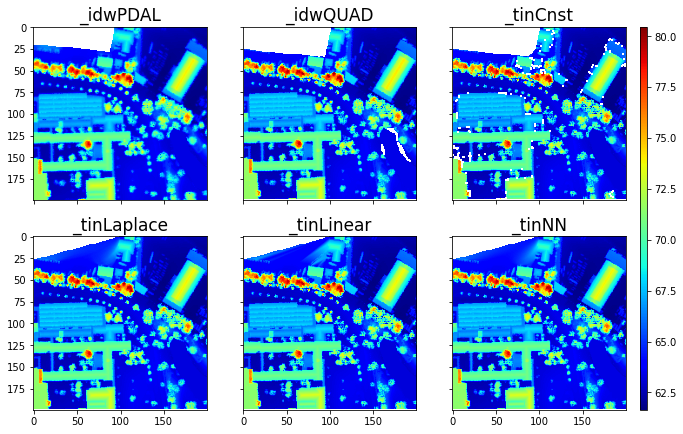

In [26]:
#with flat and constraint
plot_ra_tif('./[!o]**/CPUT_Lidar_dsm*.tif')

#### dsm difference

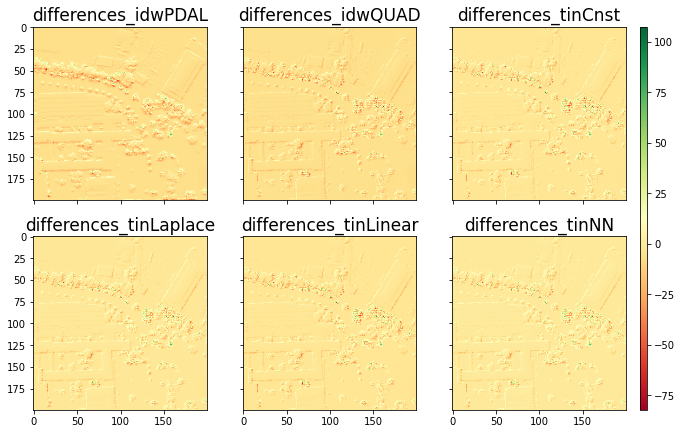

In [32]:
plot_ra_tif('./vDiff/**/CPUT_Lidar_dsm*vertical*.tif', diff = True)

#### Mean Average Error

In [34]:
with open('./vDiff/MAE_cput-report_dtm.txt', 'r') as text:
    textfile = text.read()
    print(textfile)

MAE for idwPDAL_CPUT_Lidar_dtm_flat = 0.10191983429559365
MAE for idwQUAD_CPUT_Lidar_dtm_flat = 0.0655137923807095
MAE for tinNN_CPUT_Lidar_dtm_flat = 0.06658194056850113
MAE for tinLaplace_CPUT_Lidar_dtm_flat = 0.06438860087917118
MAE for tinLinear_CPUT_Lidar_dtm_flat = 0.06538686256688073
MAE for tinCnst_CPUT_Lidar_dtm_flat = 0.06736004563749674



In [33]:
with open('./vDiff/MAE_cput-report_dsm.txt', 'r') as text:
    textfile = text.read()
    print(textfile)

MAE for idwPDAL_CPUT_Lidar_dsm = 3.1828454896953455
MAE for idwQUAD_CPUT_Lidar_dsm = 2.9755845947780815
MAE for tinNN_CPUT_Lidar_dsm = 3.1766841572803233
MAE for tinLaplace_CPUT_Lidar_dsm = 3.053770063796926
MAE for tinLinear_CPUT_Lidar_dsm = 3.4905619095080023
MAE for tinCnst_CPUT_Lidar_dsm = 3.489228670382503

